In [184]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


 import CSV

In [185]:
df = pd.read_csv('ufo_sightings_scrubbed.csv', low_memory=False)

 going to print a few rows so i can how its structured

In [186]:
print("First 5 rows of the dataset:")
print(df.head())
print("\nColumns in the dataset:")
print(df.columns)
print("\nDataset Info:")
print(df.info())

First 5 rows of the dataset:
              datetime                  city state country     shape  \
0  1949-10-10 20:30:00            san marcos    tx      us  cylinder   
1  1949-10-10 21:00:00          lackland afb    tx     NaN     light   
2  1955-10-10 17:00:00  chester (uk/england)   NaN      gb    circle   
3  1956-10-10 21:00:00                  edna    tx      us    circle   
4  1960-10-10 20:00:00               kaneohe    hi      us     light   

  duration (seconds) duration (hours/min)  \
0               2700           45 minutes   
1               7200              1-2 hrs   
2                 20           20 seconds   
3                 20             1/2 hour   
4                900           15 minutes   

                                            comments date posted    latitude  \
0  This event took place in early fall around 194...  2004-04-27  29.8830556   
1  1949 Lackland AFB&#44 TX.  Lights racing acros...  2005-12-16    29.38421   
2  Green/Orange circular di

 pre processing : cleaning the data, checking for missing values & duplicates

In [187]:
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
datetime                   0
city                       0
state                   5797
country                 9670
shape                   1932
duration (seconds)         0
duration (hours/min)       0
comments                  15
date posted                0
latitude                   0
longitude                  0
dtype: int64


 dropping rows with missing values

In [188]:
df = df.dropna()

dropping duplicates

In [189]:
df = df.drop_duplicates()

converting the datetime column to be more useful in my data set, i found out later on that having it in one column alone was posing a challenge and not providing me much, once i break the date up into year, month, day, hour, etc, i am going to drop the datetime so it doesnt overlap with the new columns

In [190]:
df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
df['year'] = df['datetime'].dt.year
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['hour'] = df['datetime'].dt.hour
df['minute'] = df['datetime'].dt.minute
df['day_of_week'] = df['datetime'].dt.dayofweek

df.drop('datetime', axis=1, inplace=True)

now im going to do the same thing with the date posted, this will help me check similarities such as day of the week, minute, etc

In [191]:
df.rename(columns={'date posted': 'date_posted'}, inplace=True)
df['date_posted'] = pd.to_datetime(df['date_posted'], errors='coerce')

df['posted_year'] = df['date_posted'].dt.year
df['posted_month'] = df['date_posted'].dt.month
df['posted_day'] = df['date_posted'].dt.day
df['posted_day_of_week'] = df['date_posted'].dt.dayofweek

df.drop('date_posted', axis=1, inplace=True)

i realized later (thanks to an error) that the hours/min field has some non numerical values like "less than a minute" that is throwing an error in my model, so I am going to drop that

In [192]:
df.drop('duration (hours/min)', axis=1, inplace=True)


since there are thousands and thousands of cities, i am going to analyze the frequency of the cities having a sighting rather than one by one, then ill drop the original column so it doesnt interfere with the new frequency of sightings count

In [193]:
city_counts = df['city'].value_counts()
df['city_freq'] = df['city'].map(city_counts)
df.drop('city', axis=1, inplace=True)

i am going to also drop the comments column due to it having no similarities or distinction since it was written by the person who seen the ufo

In [194]:
df.drop('comments', axis=1, inplace=True)

i am going to predict the sighting to be usual or unusual with the help of the most common shapes, if it is a very common shape, it will be usual versus one that has a unique shape it will be considered unusual, then i want to see if my data is balanced, then i will drop the original shapes column since i will have my own for classification

In [195]:
common_shapes = ['circle', 'triangle', 'disk', 'light', 'fireball']
df['usual_unusual'] = df['shape'].apply(lambda x: 'usual' if str(x).lower() in common_shapes else 'unusual')

print("Target column distribution:")
print(df['usual_unusual'].value_counts())
df.drop('shape', axis=1, inplace=True)

Target column distribution:
usual_unusual
usual      37035
unusual    29481
Name: count, dtype: int64


i am now going to do a overview of all my columns since i dropped and added a good bit

In [196]:
print("Columns after organizing the dataset:")
print(df.columns)

Columns after organizing the dataset:
Index(['state', 'country', 'duration (seconds)', 'latitude', 'longitude ',
       'year', 'month', 'day', 'hour', 'minute', 'day_of_week', 'posted_year',
       'posted_month', 'posted_day', 'posted_day_of_week', 'city_freq',
       'usual_unusual'],
      dtype='object')


since state and country dont have a large amount, i dont need to do the frequency like i did cities

In [197]:
categorical_cols = ['state', 'country']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

seperating

In [198]:
target_column = 'usual_unusual'
X = df.drop(target_column, axis=1)
y = df[target_column]

print("Features shape:", X.shape)
print("Target distribution:")
print(y.value_counts())

Features shape: (66516, 83)
Target distribution:
usual_unusual
usual      37035
unusual    29481
Name: count, dtype: int64


splitting the data now into training then testing

In [199]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


using random forest classifier, i liked it best for classification fgor the multiple decision trees and how versatile it is with different data types. since my dataset has a good amount of different columns, and data types, it seemed like a good fit.

In [201]:
model = RandomForestClassifier(n_estimators=200, class_weight='balanced', max_depth=10, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=200,
                       random_state=42)

predicting and printing the metrics for evaluation

In [202]:
y_pred = model.predict(X_test)

calculating accuracy

In [203]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5661455201443175


classification report

In [204]:
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

     unusual       0.51      0.47      0.49      5835
       usual       0.61      0.64      0.62      7469

    accuracy                           0.57     13304
   macro avg       0.56      0.56      0.56     13304
weighted avg       0.56      0.57      0.56     13304



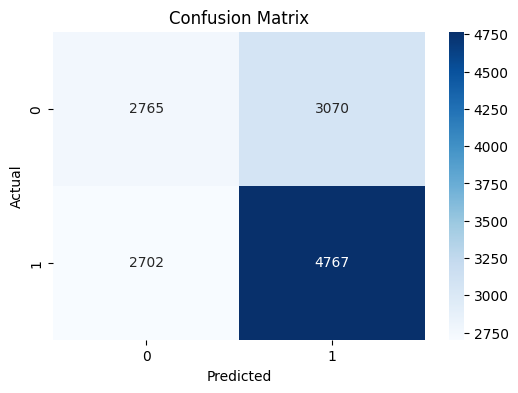

In [205]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()